# Calculation of Value At Risk with Historical Method

### We start by importing the necessary libraries.

In [98]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf #yahoo finance
import matplotlib.pyplot as plt
from scipy.stats import norm

### We then set time for a certain number of days

In [99]:
years = 15
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days = years*365)

### We create a list of assets

In [100]:
assets = ['QQQ','GLD','SPY','VTI','BND'] 

### Daily adjusted prices:

In [101]:
adj_close_df = pd.DataFrame()

data = yf.download(assets, start = startDate, end  = endDate, auto_adjust=False)
adj_close_df = data['Adj Close']
print(adj_close_df)

[*********************100%***********************]  5 of 5 completed

Ticker            BND         GLD         QQQ         SPY         VTI
Date                                                                 
2010-11-04  54.034721  136.029999   47.042816   93.314156   48.054508
2010-11-05  53.806732  136.380005   47.042816   93.665237   48.269218
2010-11-08  53.819729  137.779999   47.104156   93.489746   48.207867
2010-11-09  53.546181  135.589996   46.849972   92.818077   47.832077
2010-11-10  53.526619  137.240005   47.086636   93.192062   48.039154
...               ...         ...         ...         ...         ...
2025-10-24  75.019997  377.519989  617.099976  677.250000  333.709991
2025-10-27  75.059998  367.010010  628.090027  685.239990  337.429993
2025-10-28  75.099998  364.380005  632.919983  687.059998  337.950012
2025-10-29  74.730003  363.000000  635.770020  687.390015  337.709991
2025-10-30  74.599998  370.130005  626.049988  679.830017  334.079987

[3770 rows x 5 columns]


### Log returns (rendements)

In [102]:
log_returns = np.log(adj_close_df/adj_close_df.shift(1))
log_returns.dropna()
print(log_returns)

Ticker           BND       GLD       QQQ       SPY       VTI
Date                                                        
2010-11-04       NaN       NaN       NaN       NaN       NaN
2010-11-05 -0.004228  0.002570  0.000000  0.003755  0.004458
2010-11-08  0.000242  0.010213  0.001303 -0.001875 -0.001272
2010-11-09 -0.005096 -0.016023 -0.005411 -0.007210 -0.007826
2010-11-10 -0.000365  0.012096  0.005039  0.004021  0.004320
...              ...       ...       ...       ...       ...
2025-10-24  0.001334 -0.003358  0.010622  0.008139  0.008124
2025-10-27  0.000533 -0.028234  0.017652  0.011729  0.011086
2025-10-28  0.000533 -0.007192  0.007660  0.002652  0.001540
2025-10-29 -0.004939 -0.003794  0.004493  0.000480 -0.000710
2025-10-30 -0.001741  0.019451 -0.015407 -0.011059 -0.010807

[3770 rows x 5 columns]


### Create an equally distributed portfolio (many assets)

In [103]:
portfolio_value = 1000000
weights = np.array([1/len(assets)]*len(assets))
print(weights)

[0.2 0.2 0.2 0.2 0.2]


### Calculate the historical portfolio returns

In [104]:
historical_returns = (weights*log_returns).sum(axis = 1)
print(historical_returns)

Date
2010-11-04    0.000000
2010-11-05    0.001311
2010-11-08    0.001722
2010-11-09   -0.008313
2010-11-10    0.005022
                ...   
2025-10-24    0.004972
2025-10-27    0.002553
2025-10-28    0.001039
2025-10-29   -0.000894
2025-10-30   -0.003912
Length: 3770, dtype: float64


### Fin the x-days historical returns

In [105]:
days = 5

range_returns = historical_returns.rolling(window = days).sum()
range_returns = range_returns.dropna()
print(range_returns)

Date
2010-11-10   -0.000258
2010-11-11   -0.002142
2010-11-12   -0.018422
2010-11-15   -0.024346
2010-11-16   -0.027237
                ...   
2025-10-24    0.006415
2025-10-27   -0.005241
2025-10-28    0.008923
2025-10-29    0.012204
2025-10-30    0.003757
Length: 3766, dtype: float64


# --- Historical Method ---

### Find the VaR (historical)

In [106]:
confidence_level = 0.95
VaR = -np.percentile(range_returns, (1-confidence_level)*100)*portfolio_value
print(VaR)

23421.136773818856


C:\Users\maxim\AppData\Local\Temp\ipykernel_16996\4161824951.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


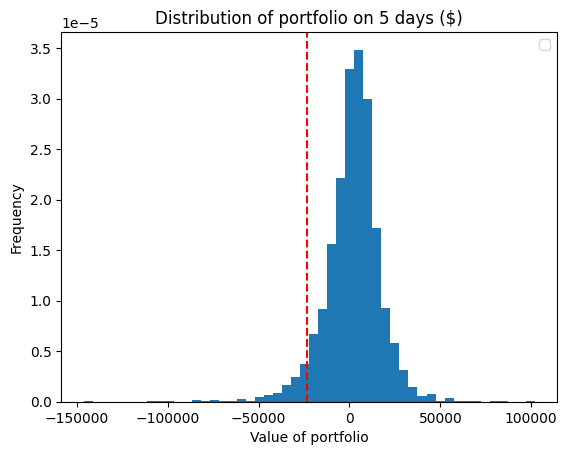

In [107]:
range_return_dollar = range_returns*portfolio_value

plt.hist(range_return_dollar.dropna(), bins = 50, density=True)
plt.xlabel("Value of portfolio")
plt.ylabel("Frequency")
plt.title(f"Distribution of portfolio on {days} days ($)")
plt.axvline(-VaR, color = 'r', linestyle = 'dashed')
plt.legend()
plt.show()


# --- Parametric Method ---

### Covariance Matrix

In [108]:
cov_matrix = log_returns.cov() * 252 #there's 252 trading days in a year
print(cov_matrix)

Ticker       BND       GLD       QQQ       SPY       VTI
Ticker                                                  
BND     0.002424  0.002315  0.000432  0.000229  0.000284
GLD     0.002315  0.024870  0.001438  0.001115  0.001238
QQQ     0.000432  0.001438  0.042987  0.033228  0.033835
SPY     0.000229  0.001115  0.033228  0.029601  0.030144
VTI     0.000284  0.001238  0.033835  0.030144  0.030939


### Calculate Portfolio Standard Deviation

In [109]:
std_dev = np.sqrt(weights.T @ cov_matrix @ weights)
print(std_dev)

0.11650499588137568


### Calculate different Parametric VaR's

In [110]:
confidence_levels_list = [0.9, 0.95, 0.99]
VaRs = []
for cl in confidence_levels_list:
    VaR = std_dev * norm.ppf(cl)* portfolio_value * np.sqrt(days/252)
    VaRs.append(VaR)
    print(f"For the confidence level: {cl}, we have a VaR = {VaR}")

For the confidence level: 0.9, we have a VaR = 21031.26357029925
For the confidence level: 0.95, we have a VaR = 26993.334558706196
For the confidence level: 0.99, we have a VaR = 38177.18819169553


C:\Users\maxim\AppData\Local\Temp\ipykernel_16996\3858248642.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


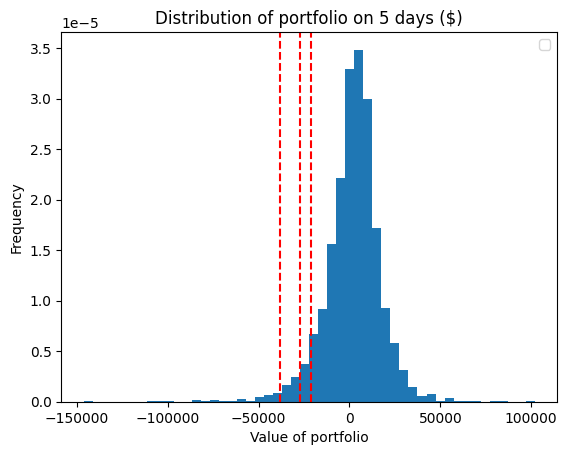

In [111]:
range_return_dollar = range_returns*portfolio_value

plt.hist(range_return_dollar.dropna(), bins = 50, density=True)

for cl, VaR in zip(confidence_levels_list, VaRs):
    plt.axvline(-VaR, color = 'r', linestyle = 'dashed')
    
plt.xlabel("Value of portfolio")
plt.ylabel("Frequency")
plt.title(f"Distribution of portfolio on {days} days ($)")
plt.legend()
plt.show()
